# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Четвёртая лабораторная работа </center>
# <center> Акустические признаки </center>

In [1]:
from glob import glob
import hashlib
import IPython.display as ipd
import os

import librosa
import librosa.display
import librosa.filters
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy
import scipy.fft
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [2]:
# Функция отрисовки аудиосигнала.
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    plt.grid(True)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()

In [3]:
# Для выполнения задания нам понадобится датасет yes/no. 
# Про датасет можно почитать тут: https://www.openslr.org/1/

# Скачаем его:
!rm -f waves_yesno.tar.gz
!wget -q https://www.openslr.org/resources/1/waves_yesno.tar.gz
# Распакуем:
!tar -xzf waves_yesno.tar.gz

# P.S Если по каким-либо причинам данные не скачались, 
# их можно загрузить отсюда: https://www.openslr.org/1/

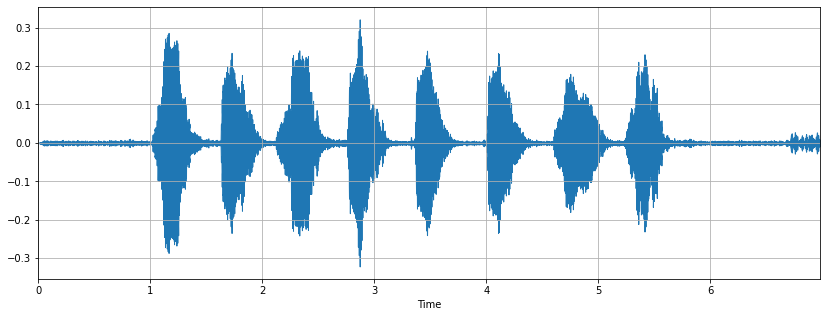

In [4]:
# Загрузим один из файлов:
wav, sr = librosa.load("waves_yesno/0_1_0_1_1_1_0_0.wav")
draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

Как можно услышать, в этом датасете произносятся какие-то два слова (yes/no на иврите). Каждый файл состоит из 8 произнесений. Метки слов указаны в названиях файлов.

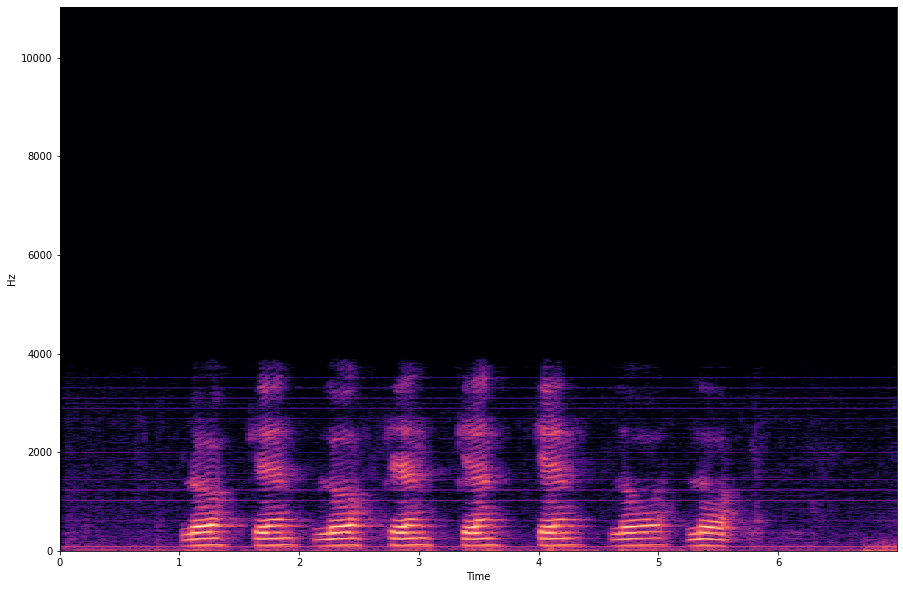

In [5]:
# Построим спектрограмму загруженного файла:
stft = librosa.stft(wav)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(15, 10))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz');

# Задание 0.1: Анализ спектрограммы (0.5 балла)
1. Посмотрите на спектрограмму и попробуйте найти признаки, по которым можно отличить произнесение "yes" от "no".
2. В каких частотах находится основная энергия этого речевого сигнала?

1. О произнесении "yes" можно судить по высокой энергии сигнала в высокочастотной области (от 1000 до 3000 Гц), в то время как для "no" характерна только низкочастотная область (до 1000 Гц).
2. Энергия этого речевого сигнала находится в диапазоне (0÷4000) Гц, основная её часть — в диапазоне (0÷1000) Гц.

# Задание 1: Мел-шкала (1 балл)
Нарисовать спектрограму в [mel-шкале](https://en.wikipedia.org/wiki/Mel_scale). 
Использовать формулу, представленную Дугласом О'Шонесси.

In [6]:
def mel(spec):
    # spec — stft spectrogram
    mel_spec = 2595.0 * np.log10(1.0 + spec / 700.0)
    return mel_spec

In [7]:
def test_mel():
    x = np.random.randint(100, size=(1000, 100))
    x_mel = mel(x)
    x_hz = 700.0 * (10.0 ** (x_mel / 2595.0) - 1.0)
    assert np.allclose(x, x_hz), "TEST Hertz -> Mel -> Hertz failed."
    print("All OK!")

In [8]:
test_mel()

All OK!


# Мел-фильтры
Одними из наиболее популярных акустических признаков являются Filter Banks (fbanks).
fbanks вычисляются применением нескольких (количество фильтров = количество fbanks) треугольных фильтров к мел-спектрограмме. Чтобы не делать два действия со спектрограммой, переход к мел-шкале и применение фильтров в мел-шкале можно заменить на перевод мел-фильтров в Герц-шкалу и применение их к Герц-спектрограмме.

## Задание 2 (3 балла)
Реализуйте функцию вычисления fbank.

In [9]:
def mel_filters(sr, n_fft, n_mels):
    """
    Функция построения треугольных мел-фильтров в герц-шкале
    :param sr — sample rate
    :param n_fft — length of the FFT window
    :param n_mels — number of filters
    :return mel filters matrix of shape [n_mels, n_fft // 2 + 1]
    """
    # Initialize the weights
    weights = np.zeros((n_mels, 1 + n_fft // 2))

    # Center freqs of each FFT bin
    fft_freqs = np.linspace(0, sr / 2, 1 + n_fft // 2)

    # "Center freqs" of mel bands — uniformly spaced between limits
    mel_freqs = np.linspace(mel(0.0), mel(sr / 2), n_mels + 2)
    mel_freqs = 700.0 * (10.0 ** (mel_freqs / 2595.0) - 1.0)

    f_diff = np.diff(mel_freqs)
    ramps = np.subtract.outer(mel_freqs, fft_freqs)

    for i in range(n_mels):
        # lower and upper slopes for all bins...
        lower = -ramps[i] / f_diff[i]
        upper = ramps[i + 2] / f_diff[i + 1]

        # ...then intersect them with each other and zero:
        weights[i] = np.maximum(0, np.minimum(lower, upper))

    enorm = 2.0 / (mel_freqs[2:n_mels + 2] - mel_freqs[:n_mels])
    weights *= enorm[:, np.newaxis]

    return weights

In [10]:
assert mel_filters(32, 46, 4).shape == (4, 24) and \
       mel_filters(65, 45, 5).shape == (5, 23), "Wrong shape."
assert np.allclose(mel_filters(16, 8, 4),
                   librosa.filters.mel(16, 8, n_mels=4, htk=True))
assert np.allclose(mel_filters(8600, 512, 40),
                   librosa.filters.mel(8600, 512, n_mels=40, htk=True))
print("All OK!")

All OK!


In [11]:
def get_fbanks(wav: np.ndarray, sr: int, window_ms=25, step_mc=10, n_fbanks=40):
    # wav — input signal
    # sr — sample rate
    # window_ms — window length in milliseconds
    # step_ms — stft step in milliseconds
    # n_fbanks — number of filters
    # return fbank matrix [n_fbanks, time]
    n_fft = window_ms * sr // 1000
    hop_length = step_mc * sr // 1000

    wav_padded = np.pad(wav, int(n_fft // 2), mode="reflect")
    window = scipy.signal.get_window("hann", Nx=n_fft)

    spectrogram = np.zeros((n_fft // 2 + 1, len(wav) // hop_length + 1),
                           dtype=np.complex64)

    for i in range(spectrogram.shape[1]):
        j = i * hop_length
        spectrogram[:, i] = np.abs(
            scipy.fft.fft(wav_padded[j:j + n_fft] * window)[:1 + n_fft // 2]
        ) ** 2

    mel_basis = mel_filters(sr=sr, n_fft=n_fft, n_mels=n_fbanks)

    return np.dot(mel_basis, spectrogram)

In [12]:
def test_fbank(wav, sr, window_ms=25, step_mc=10, n_fbanks=40):
    n_fft = window_ms * sr // 1000
    hop_length = step_mc * sr // 1000
    fbanks_lib = librosa.feature.melspectrogram(wav, sr, n_fft=n_fft,
                                                hop_length=hop_length,
                                                n_mels=n_fbanks, htk=True)
    fbanks = get_fbanks(wav, sr, window_ms=window_ms,
                        step_mc=step_mc, n_fbanks=n_fbanks)

    if fbanks_lib.shape != fbanks.shape:
        print("TEST FAILED")
        print(f"Shape {fbanks_lib.shape} != {fbanks.shape}.")
    if not np.allclose(fbanks_lib, fbanks):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(fbanks_lib - fbanks))}.")
        return -1
    print("TEST PASSED")
    return 0
assert test_fbank(wav[:sr * 1], sr) == 0, "1 sec wav test failed."
assert test_fbank(wav, sr) == 0 , "All wav tests failed."
print("All OK!")

TEST PASSED
TEST PASSED
All OK!


/usr/local/lib/python3.7/dist-packages/librosa/display.py:823: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


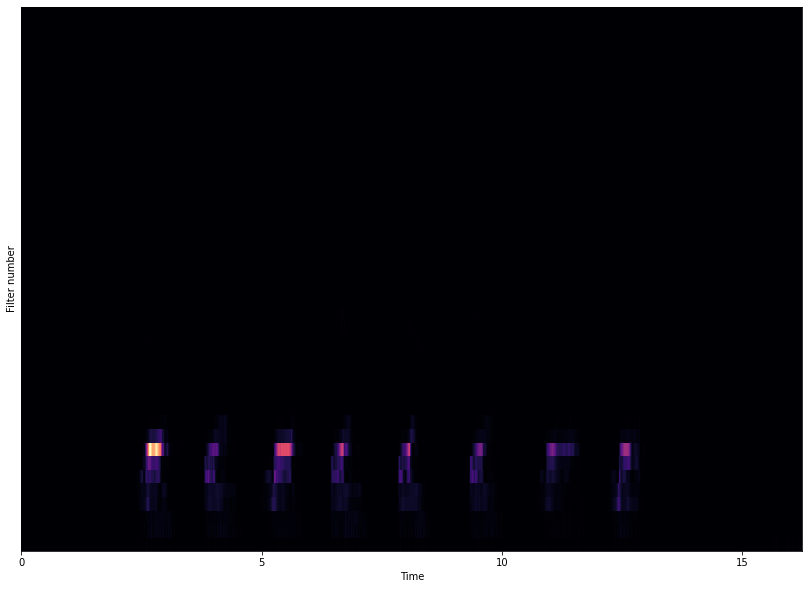

In [13]:
fbanks = get_fbanks(wav, sr)
plt.figure(figsize=(14, 10))
librosa.display.specshow(fbanks, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

## Задание 3 (3 балла)

Реализовать вычисление [mfcc](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).

In [14]:
def dct(S):
    """DCT (type 2)"""
    N = S.shape[0]
    k = np.arange(N).reshape(1, -1)
    n = np.arange(N).reshape(-1, 1)
    M = 2 * np.dot(S.T, np.cos(np.pi * (n + 0.5) * k / N)).T
    M[0, :] /= np.sqrt(2)
    M /= np.sqrt(2 * N)
    return M

In [15]:
def get_mfcc(wav: np.ndarray, sr: int, window_ms=25, step_mc=10, n_mfcc=13):
    # wav — input signal
    # sr — sample rate
    # window_ms — window length in milliseconds
    # step_ms — stft step in milliseconds
    # n_mfcc — number of filters
    # return mfcc matrix [n_mfcc, time]
    n_fft = window_ms * sr // 1000
    hop_length = step_mc * sr // 1000

    # Get mel-spectrogram
    mel_spec = get_fbanks(wav, sr, window_ms=window_ms, step_mc=step_mc)

    # Convert power to decibels
    magnitude = np.abs(mel_spec)
    log_spec = 10.0 * np.log10(np.maximum(1e-10, magnitude))
    log_spec = np.maximum(log_spec, log_spec.max() - 80.0)

    # Apply discrete cosine transform (type 2)
    mfcc = dct(log_spec)[:n_mfcc]

    return mfcc

In [16]:
def test_mfcc(wav, sr, window_ms=25, step_mc=10, n_mfcc=13):
    n_fft = window_ms * sr // 1000
    hop_length = step_mc * sr // 1000
    mfcc_lib = librosa.feature.mfcc(wav, sr, n_fft=n_fft, hop_length=hop_length,
                                    n_mels=40, n_mfcc=n_mfcc, htk=True)
    mfcc = get_mfcc(wav, sr, window_ms=window_ms,
                    step_mc=step_mc, n_mfcc=n_mfcc)

    if mfcc_lib.shape != mfcc.shape:
        print("TEST FAILED")
        print(f"Shape {mfcc_lib.shape} != {mfcc.shape}.")
    if not np.allclose(mfcc_lib, mfcc, atol=1e-4):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(mfcc_lib - mfcc))}.")
        return -1
    print("TEST PASSED")
    return 0
assert test_mfcc(wav[:sr * 1], sr) == 0, "1 sec wav test failed."
assert test_mfcc(wav, sr) == 0 , "All wav tests failed."
print("All OK!")

TEST PASSED
TEST PASSED
All OK!


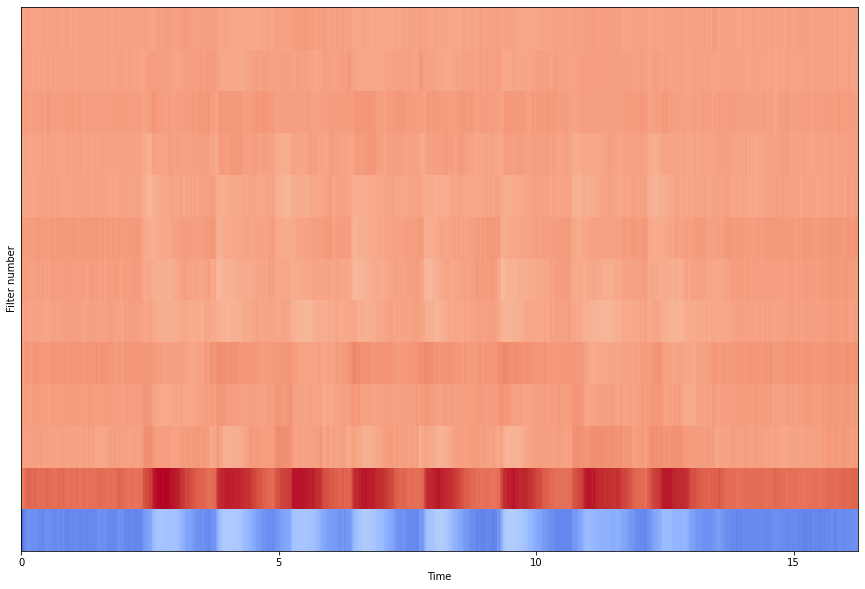

In [17]:
mfcc = get_mfcc(wav, sr)
plt.figure(figsize=(15, 10))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Классификация слов
Построим простую систему, классифицирующую слова yes/no.

Загрузим весь датасет:

In [18]:
def load_yn_dataset(directory):
    X, labels = [], []
    for f in glob(directory + "/*.wav"):
        name = os.path.basename(f)[:-4]
        y = [int(l) for l in name.split("_")]
        x, _ = librosa.load(f)
        X.append(x)
        labels.append(y)

    return X, labels

X, Y = load_yn_dataset("waves_yesno/")

Отделим 20% для теста:

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=1
)

In [20]:
# 6-th sample of X_test is corrupted, let's remove it:
X_test = X_test[:6] + X_test[7:]
Y_test = Y_test[:6] + Y_test[7:]

## Задание 4* (1 балл)
Voice Activity Detector (VAD) определяет, есть ли речь в текущем кадре или нет.

Реализуйте простой VAD.

Настройте VAD, чтобы хорошо определялись границы слов.

In [21]:
def moving_average(data, window):
    """Moving average filter"""
    return np.convolve(data, np.ones(window), "same") / window


def detect_va(x, sr=22050):
    """Voice activity detector"""
    mfcc = get_mfcc(x, sr=sr)
    # Moving average filter and level adjusting:
    mfcc_smoothed = moving_average(mfcc[1], 10) - 125
    vad = np.zeros_like(mfcc_smoothed)
    vad[mfcc_smoothed > 0] = 1
    return vad

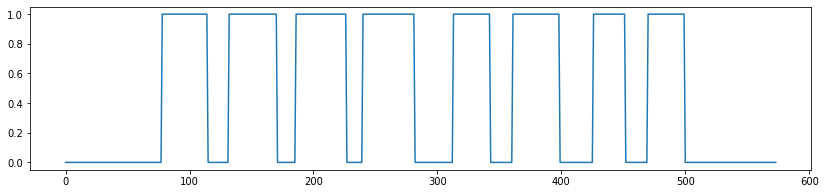

In [22]:
plt.figure(figsize=(14, 3))
plt.plot(detect_va(X_train[6]));

In [23]:
# train_VA: 1 — voice, 0 - silence
# test_VA:  1 - voice, 0 - silence
train_VA = [detect_va(x) for x in X_train]
test_VA = [detect_va(x) for x in X_test]

In [24]:
def test_VAD(VA, Y):
    def check_diff(diff, num_words):
        if diff.sum() != 0:
            print("VAD detected speech at the beginning (or end) of audio.")
            return -1
        if not (diff > 0).sum() == num_words:
            print("Wrong number of words. Each audio contains 8 words.")
            return -2
        return 0

    for i, (va, y) in enumerate(zip(VA, Y)):
        diff = va[1:] - va[:-1]
        assert check_diff(diff, len(y)) == 0, f"Bad {i}-th example."

test_VAD(train_VA, Y_train)
test_VAD(test_VA, Y_test)

## Задание 5* (2 балла)
Обучите классификатор, определяющий, какое слово было сказано. Используйте VAD для разбиения входных файлов на отдельные слова. Классификацию можно сделать, например, с помощью SVM по усреднённым признакам выделеных слов или любым другим удобным для вас способом.

In [25]:
def prepare_dataset(x, vad, y):
    train, target = [], []
    for i, (xi, vai, yi) in enumerate(zip(x, vad, y)):
        mfcc = get_mfcc(xi, sr=22050)
        # Get indices of VAD changing values:
        indices = np.where(vai[:-1] != vai[1:])[0] + 1
        # Extract speech parts from signal:
        for j in range(0, len(indices), 2):
            sample = np.mean(mfcc[:, indices[j]:indices[j + 1]], axis=1)
            train.append(sample)
            target.append(yi[j // 2])
    return np.array(train), np.array(target)

In [26]:
x_train, y_train = prepare_dataset(X_train, train_VA, Y_train)
x_test, y_test = prepare_dataset(X_test, test_VA, Y_test)

In [27]:
print(f"Train set class balance: " \
      f"{len(y_train[y_train == 1]) / len(y_train) * 100:.2f}%")
print(f"Test set class balance:  " \
      f"{len(y_test[y_test == 1]) / len(y_test) * 100:.2f}%")

Train set class balance: 52.60%
Test set class balance:  53.41%


The classes are well balanced, we can use accuracy as evaluation metric.

In [28]:
clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=44, tol=1e-5))
clf.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvc',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=44,
                           tol=1e-05, verbose=0))],
         verbose=False)

In [29]:
print(f"Accuracy: {accuracy_score(y_test, clf.predict(x_test)) * 100:.2f}%.")

Accuracy: 100.00%.


Wow, the model achieved 100% accuracy! Let's do PCA and check if the samples can really be perfecty separated by some decision boundary.

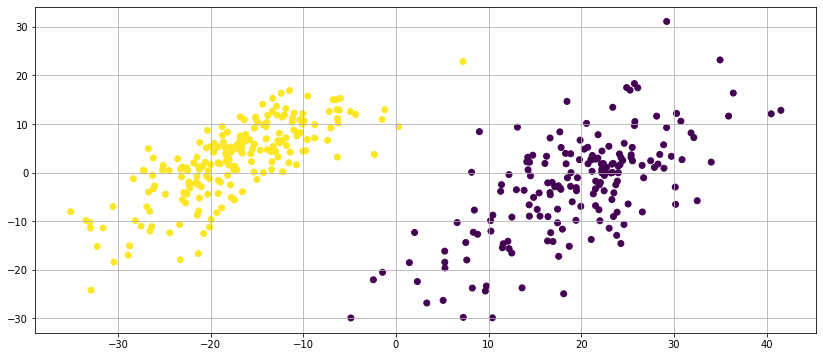

In [30]:
pca = PCA(n_components=2)
y_pca = pca.fit_transform(x_train)

plt.figure(figsize=(14, 6))
plt.scatter(y_pca[:, 0], y_pca[:, 1], c=y_train)
plt.grid()
plt.show()

The data is really perfectly separable, it's alright to have 100% accuracy.